In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss,normalized_mutual_info_score,roc_auc_score
from sklearn import preprocessing

In [2]:
data_jan=pd.read_csv('/data/xx715/Jan_data.csv',index_col=0)
data_feb=pd.read_csv('/data/xx715/Feb_data.csv',index_col=0)

### Features preprocessing

In [4]:
X_train1=data_jan.drop('is_churn',1)                    #drop y label
x_cols = [x for x in X_train1.columns if x != 'std_sec']#get all feature names without std_sec 
y_train=data_jan['is_churn']                            #y label
scaler=preprocessing.StandardScaler()                   
X_train=X_train1                                        
X_train[x_cols]=scaler.fit_transform(X_train1[x_cols])  #standardize all features except std_sec
X_train=pd.DataFrame(X_train,columns=X_train1.columns,index=X_train1.index)

X_val1, X_test1, y_val, y_test = train_test_split(data_feb.drop('is_churn',1),data_feb.is_churn,test_size=0.5) #split february data into validation set and test set
X_val=X_val1
X_val[x_cols]=scaler.fit_transform(X_val1[x_cols])
X_test=scaler.fit_transform(X_test1)
X_val=pd.DataFrame(X_val,columns=X_val1.columns,index=X_val1.index)
X_test=pd.DataFrame(X_test,columns=X_test1.columns,index=X_test1.index)

In [5]:
#exchange feature columns in february dataset that do not match with Janruary dataset
cols = list(X_test)
cols = cols[:41] + [cols[42]]+[cols[41]]+cols[43:]
X_test= X_test[cols]
X_val=X_val[cols]

### Plot feature importance using default Random Forest as baseline model

In [11]:
def plotFeatureImportance(X,y,rf_clf):
    
    rf_importances=rf_clf.feature_importances_
    std = np.std([rf_clf.feature_importances_ for tree in rf_clf.estimators_],
                 axis=0)
    indices = np.argsort(rf_importances)[::-1]

    plt.figure(figsize=[12,8])
    plt.title("Feature importances")
    plt.bar(range(15), rf_importances[indices],
            color="b", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), X.columns[indices],rotation='vertical')
    plt.xlim([-1, X.shape[1]])
    plt.show()
    rf_importances=pd.DataFrame(rf_importances[indices],index=X.columns[indices],columns=['Feature importances'])
    return rf_importances

In [37]:
def plot_feature_importance(importance,names):

#Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title( 'TOP 15 FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

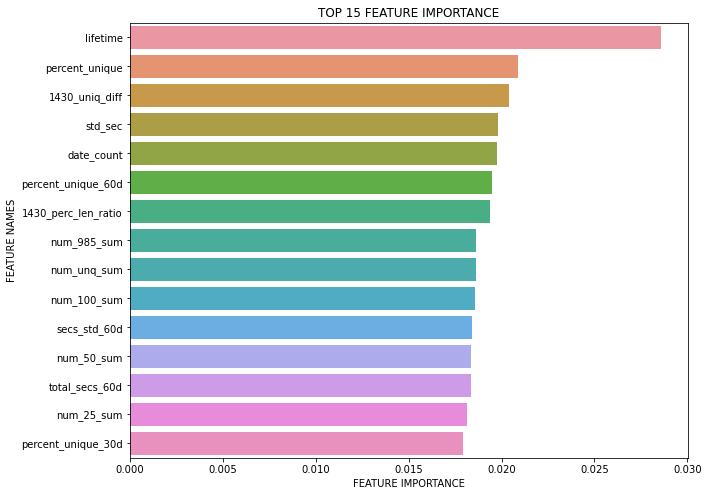

In [38]:
plot_feature_importance(rf_importances[indices],X_train.columns[indices])

In [24]:
def Mutual_Information(data,X,Y, lab, width = 0.35):
    

    cols = X.columns.values
    mis = []

    #Start by getting MI
    for c in cols:
        mis.append(normalized_mutual_info_score(Y.ravel(), X[c].values))

    #Get signs by correlation
    corrs = data.corr()[lab]
    corrs = corrs[corrs.index != lab]
    df = pd.DataFrame(zip(mis, cols, corrs), columns = ['MI', 'Feature','corr'])
    df_sorted = df.sort_values(by = ['MI'], ascending = False)
    #plot
    ind = np.arange(df_sorted.shape[0])
    feat = df_sorted['Feature'].values

    pos_mi = (df_sorted['corr'].values > 0) * df_sorted.MI
    neg_mi = (df_sorted['corr'].values < 0) * df_sorted.MI

    fig = plt.figure(facecolor = 'w', figsize = (14, 7))
    ax = plt.subplot(111)
    plt.subplots_adjust(bottom = 0.25)

    rec = ax.bar(ind + width, pos_mi, width, color='r', label = 'Positive')
    rec = ax.bar(ind + width, neg_mi, width, color='b', label = 'Negative')

    lens=list(map(len,feat))
    lens=-1 * 0.35 * (lens - np.mean(lens)) / np.max(lens)
    ax.set_xticks(ind + lens)
    ax.set_xticklabels(feat, rotation = 90, size = 10)

    plt.legend()
    return mis


### Plot ROC curve

In [29]:
from sklearn.metrics import roc_curve, auc

def plotUnivariateROC(preds, truth, label_string):
    '''
    preds is an nx1 array of predictions
    truth is an nx1 array of truth labels
    label_string is text to go into the plotting label
    '''
    #Student input code here
    #1. call the roc_curve function to get the ROC X and Y values
    fpr, tpr, thresholds = roc_curve(truth,preds)
    #2. Input fpr and tpr into the auc function to get the AUC
    roc_auc = auc(fpr,tpr)
    
    #we are doing this as a special case because we are sending unfitted predictions
    #into the function
    if roc_auc < 0.5:
        fpr, tpr, thresholds = roc_curve(truth, -1 * preds)
        roc_auc = auc(fpr, tpr)

    #chooses a random color for plotting
    c = (np.random.rand(), np.random.rand(), np.random.rand())

    #create a plot and set some options
    plt.plot(fpr, tpr, color = c, label = label_string + ' (AUC = %0.3f)' % roc_auc)
    
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC')
    plt.legend(loc="lower right")
    #indices = np.argsort(roc_auc)[::-1]
    #auc_score=pd.DataFrame(roc_auc[indices],index=X.columns[indices],columns=['AUC score'])
    
    return roc_auc

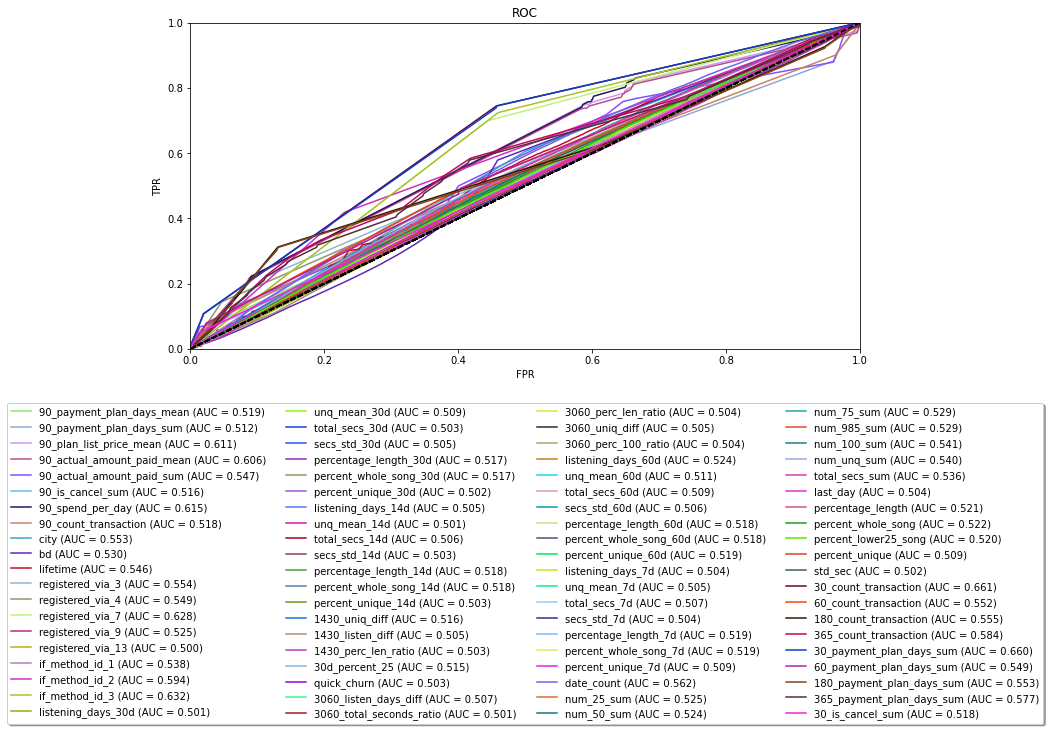

In [30]:
fig = plt.figure(figsize = (12, 6))
ax = plt.subplot(111)

#Plot the univariate AUC on the training data. Store the AUC
pred=feature_auc_dict = {}
for col in X_scaled.columns:
    #Student put code here
    feature_auc_dict[col] = plotUnivariateROC(X_scaled[col], y_scaled,col)


# Put a legend below current axis
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.0 , box.width, box.height * 1])
ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.15), fancybox = True, 
              shadow = True, ncol = 4, prop = {'size':10})

In [33]:
AUC_score=pd.DataFrame.from_dict(feature_auc_dict, orient='index',columns=['AUC score'])
AUC_score=AUC_score.sort_values(by=['AUC score'],ascending=False)
AUC_score.head(20)

,AUC score
30_count_transaction,0.660916
30_payment_plan_days_sum,0.659910
if_method_id_3,0.632249
registered_via_7,0.627645
90_spend_per_day,0.615382
90_plan_list_price_mean,0.610862
90_actual_amount_paid_mean,0.606321
if_method_id_2,0.594132
365_count_transaction,0.583783
365_payment_plan_days_sum,0.576909


### Plot feature importance for all features

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100building tree 5 of 100

building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.2s


building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   10.9s


building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   12.8s


building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   20.6s


building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100


[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   28.2s


building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100building tree 85 of 100
building tree 86 of 100

building tree 87 of 100
building tree 88 of 100


[Parallel(n_jobs=-1)]: Done  64 out of 100 | elapsed:   32.2s remaining:   18.1s


building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100


[Parallel(n_jobs=-1)]: Done  75 out of 100 | elapsed:   38.8s remaining:   12.9s


building tree 100 of 100


[Parallel(n_jobs=-1)]: Done  86 out of 100 | elapsed:   42.6s remaining:    6.9s
[Parallel(n_jobs=-1)]: Done  97 out of 100 | elapsed:   46.6s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   48.3s finished


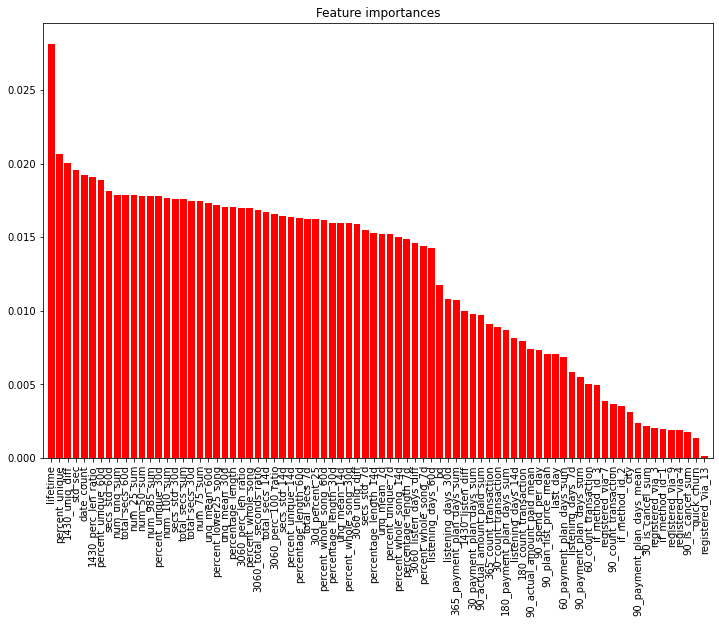

In [56]:
rf_clf1 = RandomForestClassifier(verbose=10,n_jobs=-1)
rf_clf1.fit(X,y)
rf_fi=plotFeatureImportance(X,y,rf_clf1)

In [94]:
rf_fi=pd.DataFrame(rf_fi[indices],index=X.columns[indices],columns=['Feature importances'])
rf_fi.iloc[-20:]

,Feature importances
90_plan_list_price_mean,0.007093
last_day,0.007076
60_payment_plan_days_sum,0.006837
listening_days_7d,0.005874
90_payment_plan_days_sum,0.005470
60_count_transaction,0.005016
if_method_id_3,0.004967
registered_via_7,0.003870
90_count_transaction,0.003659
if_method_id_2,0.003510


### Plot mutual information graph between each feature and the target variable

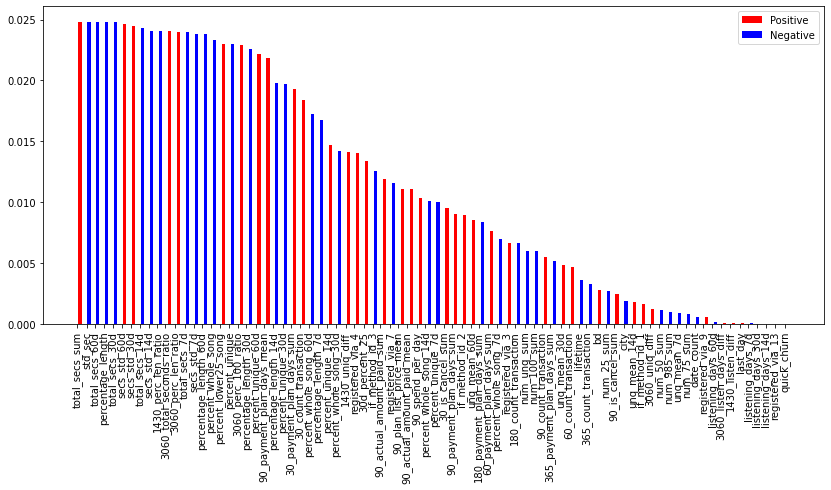

In [87]:
mi = Mutual_Information(data_jan,X_train,y_train,'is_churn')